In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [2]:
cd ../

C:\Users\akite\OneDrive\デスクトップ\source code\twitter-compe


In [3]:
train_df = pd.read_csv('./data/preprosessing_train.csv')

In [4]:
one_train_df = train_df[train_df["flg"]== 1]
zero_train_df = train_df[train_df["flg"]== 0]
zero_train_df.shape

(18851, 17)

In [5]:
X_one_df_train = one_train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_wakati"]]
Y_one_df_train = one_train_df["flg"].astype(np.int64)
X_zero_df_train = zero_train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_wakati"]]
Y_zero_df_train = zero_train_df["flg"].astype(np.int64)
X_one_train =  X_one_df_train.values
y_one_train = Y_one_df_train.values
X_zero_train =  X_zero_df_train.values
y_zero_train = Y_zero_df_train.values
from sklearn.model_selection import train_test_split
X_one_train, X_one_valid, y_one_train, y_one_valid = train_test_split(X_one_train, y_one_train, train_size=0.8, random_state=1)
X_zero_train, X_zero_valid, y_zero_train, y_zero_valid = train_test_split(X_zero_train, y_zero_train, train_size=0.8, random_state=1)
X_valid = np.concatenate([X_one_valid,X_zero_valid],0)
y_valid = np.concatenate([y_one_valid,y_zero_valid],0)

In [6]:
print(X_one_train.shape)
print(X_zero_train.shape)

(1147, 10)
(15080, 10)


In [7]:
#特徴量配列
X_one_train_feat = X_one_train[:,:8]
X_zero_train_feat = X_zero_train[:,:8]
X_valid_feat = X_valid[:,:8]

In [8]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
ss.fit( np.concatenate([X_one_train_feat,X_zero_train_feat],0))
X_one_train_feat_ss = ss.transform(X_one_train_feat)
X_zero_train_feat_ss = ss.transform(X_zero_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)

In [9]:
#単語ベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer(min_df=10/16228, max_df=3000/16228)
cv.fit( np.concatenate([X_one_train[:,9],X_zero_train[:,9]],0))
X_one_train_csr = cv.transform(X_one_train[:,9])
X_zero_train_csr = cv.transform(X_zero_train[:,9])
X_valid_csr = cv.transform(X_valid[:,9])

In [10]:
#文字配列と特徴量の配列を結合する
X_one_train = np.concatenate([X_one_train_csr.toarray(),X_one_train_feat_ss],1)
X_zero_train = np.concatenate([X_zero_train_csr.toarray(),X_zero_train_feat_ss],1)
X_valid = np.concatenate([X_valid_csr.toarray(),X_valid_feat_ss],1)

In [11]:
#型変換
X_one_train = X_one_train.astype(np.float32)
X_zero_train = X_zero_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)

In [12]:
#NN
import chainer
from chainer import training, iterators, optimizers, serializers, Chain
import chainer.functions as F
import chainer.links as L
 
from chainer.training import extensions
class Net(chainer.Chain):

    def __init__(self, n_in=4, n_hidden=1000, n_out=3):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)

        return h

In [13]:
#ログ
iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}

In [14]:
print(X_one_train.shape)
print(X_zero_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1147, 3798)
(15080, 3798)
(4058, 3798)
(4058,)


In [15]:
n_epoch = 50 #学習回数
n_batchsize = 1147 #バッチサイズ
net = Net(n_in =X_one_train.shape[1], n_hidden=10,n_out=2)

In [16]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.Adam()  # 学習率を 0.01 に設定
optimizer.setup(net)
for param in net.params():
    if param.name != 'b':  # バイアス以外だったら
        param.update_rule.add_hook(WeightDecay(0.0001))  

In [17]:
for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(X_zero_train)))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), len(X_one_train)):
        index = order[i:i+len(X_one_train)]
        #len(index)
        X_zero_train_batch = X_zero_train[index,:]
        X_train = np.concatenate([X_zero_train_batch,X_one_train],0)#連結した特徴量
        y_train = np.concatenate([np.zeros(len(X_zero_train_batch)),np.ones(len(X_one_train))],0)#連結した目標値リスト
        #print(y_train)
        shuffle= np.random.permutation(range(len(X_train)))#シャッフル用数字
        x_train_batch = np.zeros(X_train.shape,dtype=np.float32)
        t_train_batch = np.zeros(len(y_train),dtype=np.int64)
        for j in range(len(shuffle)):
            x_train_batch[j] = X_train[shuffle[j]]
            t_train_batch[j] = y_train[shuffle[j]]
        #print(t_train_batch)
        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(X_valid)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, y_valid)
    accuracy_val = F.accuracy(y_val, y_valid)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 14, loss (train): 0.6833, loss (valid): 0.6662
epoch: 1, iteration: 28, loss (train): 0.6485, loss (valid): 0.6170
epoch: 2, iteration: 42, loss (train): 0.5990, loss (valid): 0.5644
epoch: 3, iteration: 56, loss (train): 0.5396, loss (valid): 0.5091
epoch: 4, iteration: 70, loss (train): 0.4731, loss (valid): 0.4517
epoch: 5, iteration: 84, loss (train): 0.4039, loss (valid): 0.3963
epoch: 6, iteration: 98, loss (train): 0.3383, loss (valid): 0.3461
epoch: 7, iteration: 112, loss (train): 0.2812, loss (valid): 0.3037
epoch: 8, iteration: 126, loss (train): 0.2346, loss (valid): 0.2685
epoch: 9, iteration: 140, loss (train): 0.1980, loss (valid): 0.2411
epoch: 10, iteration: 154, loss (train): 0.1696, loss (valid): 0.2202
epoch: 11, iteration: 168, loss (train): 0.1471, loss (valid): 0.2050
epoch: 12, iteration: 182, loss (train): 0.1297, loss (valid): 0.1936
epoch: 13, iteration: 196, loss (train): 0.1159, loss (valid): 0.1840
epoch: 14, iteration: 210, loss (trai

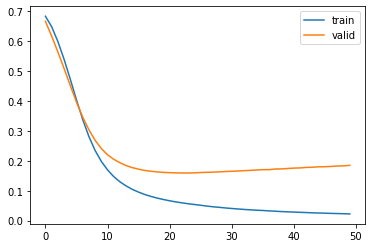

In [18]:

# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

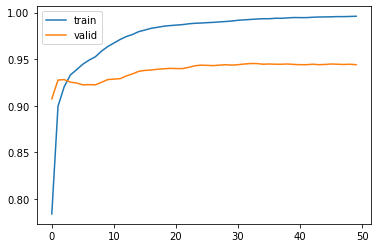

In [19]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    print("適合率:"+str(recall_score(Y_test,Y_pred)))
    print("再現率:"+str(precision_score(Y_test,Y_pred)))
    print("F値:"+str(f1_score(Y_test, Y_pred)))  
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [21]:

with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_arr = net(X_valid)

In [22]:
print(y_arr)

variable([[-6.386753    4.1123943 ]
          [-2.0180018   1.1183648 ]
          [ 0.37861565 -0.6112241 ]
          ...
          [ 2.8787844  -2.6524467 ]
          [ 3.1880794  -2.8493106 ]
          [ 3.476538   -3.149111  ]])


In [23]:

y_pred = np.zeros(X_valid.shape[0])
for i in range(X_valid.shape[0]):
    y_pred[i] = np.argmax(y_arr[i].array)


正解率:0.9440611138491868
適合率:0.7456445993031359
再現率:0.5815217391304348
F値:0.6534351145038169
[[3617  154]
 [  73  214]]


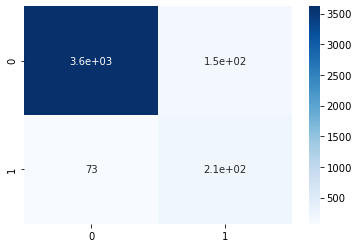

In [24]:
result_heatmap(y_valid,y_pred)